In [1]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import os
import shutil

In [ ]:
os.makedirs('/root/.kaggle', exist_ok=True)

In [ ]:
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vbookshelf/rice-leaf-diseases

Dataset URL: https://www.kaggle.com/datasets/vbookshelf/rice-leaf-diseases
License(s): unknown
  0% 0.00/36.7M [00:00<?, ?B/s]
100% 36.7M/36.7M [00:00<00:00, 1.30GB/s]


In [4]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/Bacterial leaf blight/
  inflating: dataset/Bacterial leaf blight/augmented_image_1.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_10.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_100.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_101.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_102.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_103.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_104.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_105.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_106.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_107.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_108.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_109.jpg  
  inflating: dataset/Bacterial leaf blight/augmented_image_11.jpg  
  inflating: datase

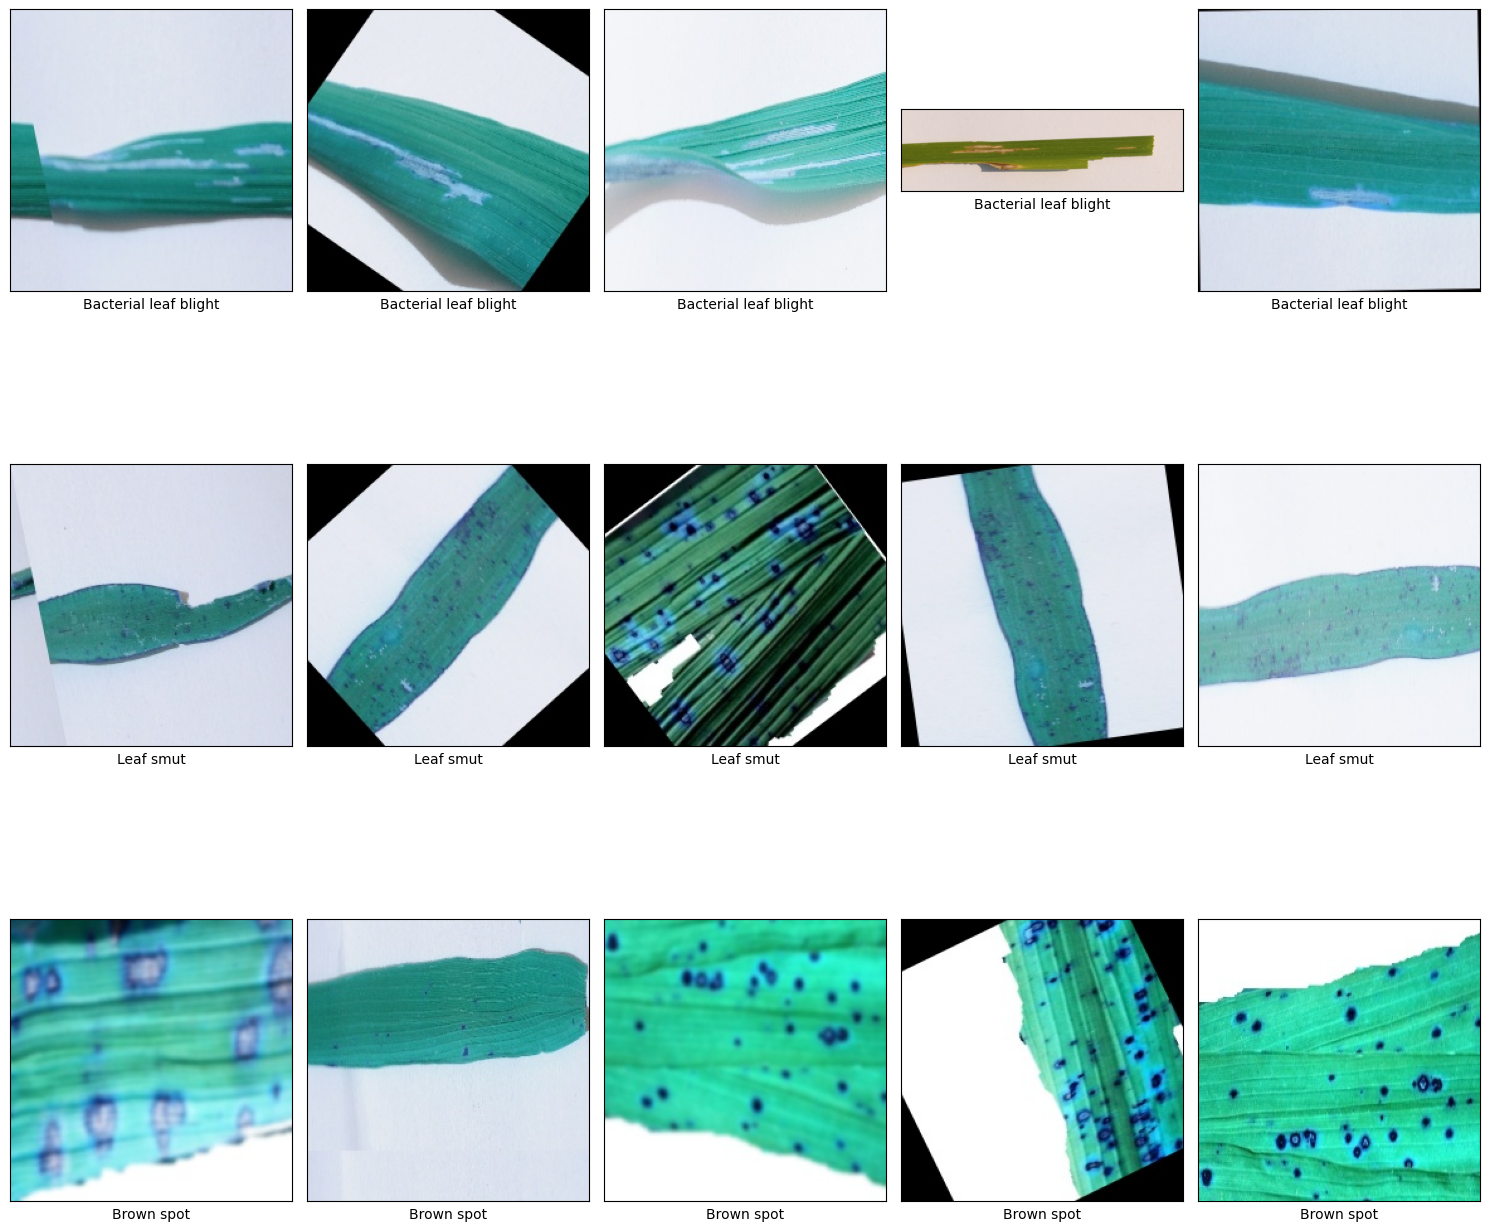

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

lung_image = {}

path_sub = os.path.join("dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "dataset/"

fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

In [6]:
directory = 'dataset/'

unique_sizes = set()
total_images = 0

for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    if os.path.isdir(subdir_path):
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except Exception as e:
                print(f"Error opening {img_path}: {e}")

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

print(f"\nTotal: {total_images}")

Bacterial leaf blight: 1000
- (224, 224)
- (3081, 897)
---------------
Leaf smut: 1000
- (4160, 2340)
- (537, 216)
- (301, 71)
- (946, 255)
- (376, 80)
- (510, 383)
- (503, 174)
- (562, 217)
- (224, 224)
- (367, 73)
- (948, 211)
- (948, 233)
- (3081, 897)
- (565, 233)
- (741, 291)
- (250, 200)
- (614, 409)
---------------
Brown spot: 1000
- (537, 216)
- (503, 174)
- (367, 73)
- (562, 217)
- (763, 268)
- (946, 255)
- (768, 514)
- (427, 193)
- (617, 244)
- (296, 88)
- (316, 127)
- (340, 94)
- (4160, 2340)
- (699, 197)
- (467, 104)
- (510, 383)
- (1200, 900)
- (224, 224)
- (1504, 323)
- (948, 233)
- (311, 170)
- (286, 92)
- (359, 168)
- (766, 250)
- (565, 233)
- (741, 291)
- (250, 200)
- (614, 409)
- (765, 224)
- (301, 71)
- (376, 80)
- (456, 124)
- (1480, 279)
- (948, 211)
- (3081, 897)
- (1530, 371)
---------------

Total: 3000


In [ ]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from skimage.filters import gaussian
import random


# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [ ]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="/content/dataset/Bacterial leaf blight"
augmented_path="/content/dataset/Bacterial leaf blight"
images=[]

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

images_to_generate=960
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0
        transformation_count = random.randint(1, len(transformations))

        while n <= transformation_count:
            key = random.choice(list(transformations))
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

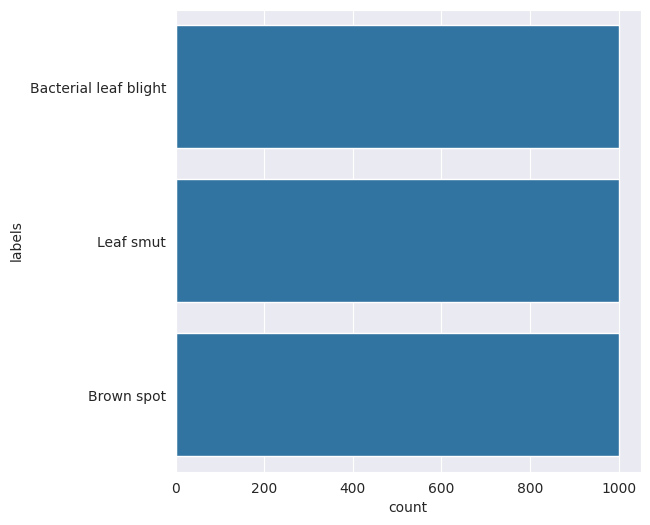

In [7]:
import pandas as pd
import seaborn as sns

lung_path = "/content/dataset"

file_name = []
labels = []
full_path = []


for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [8]:
total = len(distribution_train)
print(f"Total data: {total}")

Total data: 3000


In [9]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Bacterial leaf blight,1000
Brown spot,1000
Leaf smut,1000


In [10]:
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [11]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [12]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels               
test   Bacterial leaf blight    192
       Brown spot               204
       Leaf smut                204
train  Bacterial leaf blight    808
       Brown spot               796
       Leaf smut                796
dtype: int64 


                                                   path  \
1524  dataset/Bacterial leaf blight/augmented_image_...   
2760          dataset/Leaf smut/augmented_image_552.jpg   
23            dataset/Leaf smut/augmented_image_486.jpg   
600   dataset/Bacterial leaf blight/augmented_image_...   
1139         dataset/Brown spot/augmented_image_917.jpg   

                     labels    set  
1524  Bacterial leaf blight  train  
2760              Leaf smut   test  
23                Leaf smut  train  
600   Bacterial leaf blight  train  
1139             Brown spot  train  


In [13]:
from tqdm import tqdm as tq

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

3000it [00:00, 4394.01it/s]


In [14]:
# Definisikan direktori untuk train dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Dapatkan daftar semua kelas dalam folder train
classes = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]

# Menghitung jumlah gambar untuk setiap kelas di train dan test
for class_name in classes:
    train_path = os.path.join(TRAIN_DIR, class_name)
    test_path = os.path.join(TEST_DIR, class_name)

    # Hitung jumlah gambar di set pelatihan
    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    print(f"Total number of {class_name} images in training set: {train_count}")

    # Hitung jumlah gambar di set pengujian
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0
    print(f"Total number of {class_name} images in test set: {test_count}")

Total number of Bacterial leaf blight images in training set: 808
Total number of Bacterial leaf blight images in test set: 192
Total number of Leaf smut images in training set: 796
Total number of Leaf smut images in test set: 204
Total number of Brown spot images in training set: 796
Total number of Brown spot images in test set: 204


In [15]:
TRAIN_DIR = 'Dataset-Final/train'
TEST_DIR = 'Dataset-Final/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=24,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.25
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=8,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 1800 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.5676 - loss: 1.8057 - val_accuracy: 0.3583 - val_loss: 3.5023 - learning_rate: 0.0010
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.6994 - loss: 1.4564 - val_accuracy: 0.5300 - val_loss: 2.5681 - learning_rate: 0.0010
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.7452 - loss: 1.3318 - val_accuracy: 0.3800 - val_loss: 3.0253 - learning_rate: 0.0010
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.7508 - loss: 1.3466 - val_accuracy: 0.7083 - val_loss: 1.7424 - learning_rate: 0.0010
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.7678 - loss: 1.2472 - val_accuracy: 0.7300 - val_loss: 1.6856 - learning_rate: 0.0010
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.8190 - loss: 1.0592 - val_accuracy: 0.7417 - val_loss: 1.5285 - learning_rate: 0.0010
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.8034 - loss: 1.0720

In [18]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy : {test_acc}")

600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8832 - loss: 0.6518
Test Accuracy : 0.949999988079071


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


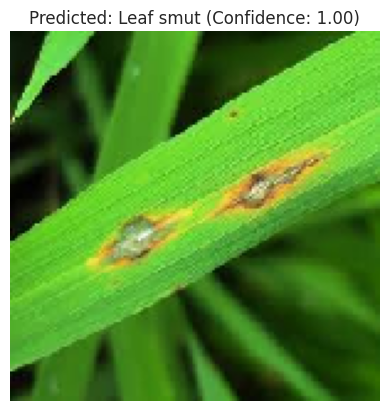

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

def predict_image(img_path, model, class_labels) :
    img = load_img(img_path, target_size=(150, 150,3), color_mode='rgb')

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype(np.float32) / 255.0

    predictions = model.predict(img_array)

    predicted_class_idx = np.argmax(predictions)
    predicted_label = class_labels[predicted_class_idx]
    confidence = np.max(predictions)

    return img, predicted_label, confidence

with open('labels.txt', 'r') as f:
    class_labels = [line.strip() for line in f.readlines()]

img_path = "/content/test6.jpeg"
img, label, confidence = predict_image(img_path, model, class_labels)

plt.imshow(img, cmap='gray')
plt.title(f"Predicted: {label} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()

In [ ]:
import shutil

shutil.make_archive('dataset', 'zip', 'dataset')

'/content/dataset.zip'

## Evaluasi dan Visualisasi

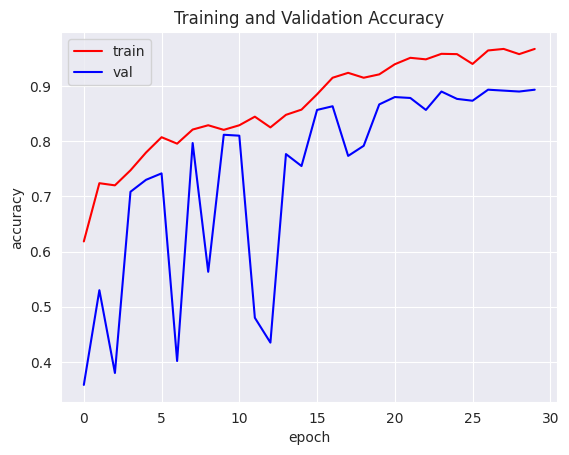

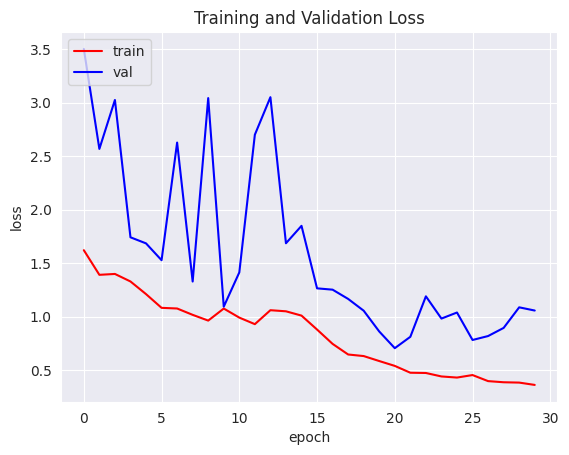

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
test_steps = test_generator.samples // test_generator.batch_size
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.93      0.96       192
           Brown spot       0.92      0.96      0.94       204
            Leaf smut       0.94      0.97      0.95       204

             accuracy                           0.95       600
            macro avg       0.95      0.95      0.95       600
         weighted avg       0.95      0.95      0.95       600



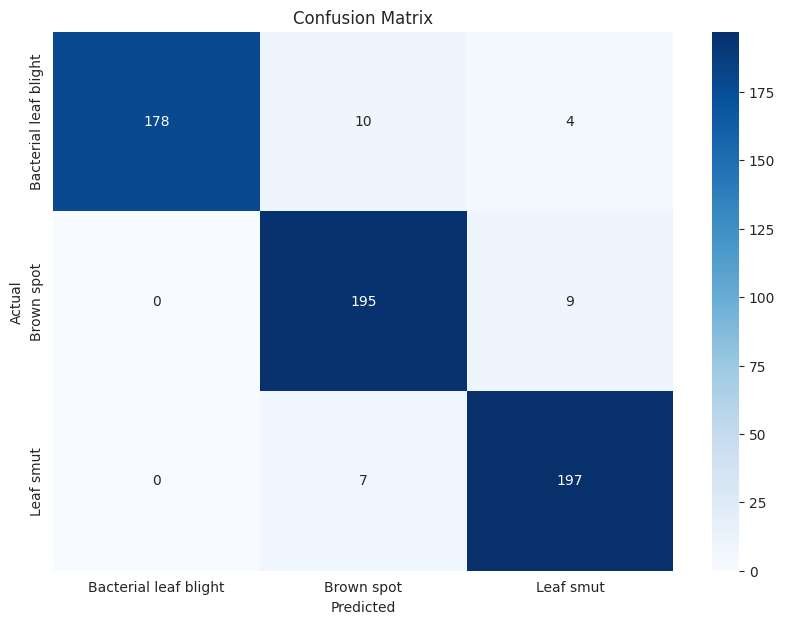

In [21]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Saved Model

In [ ]:
os.makedirs('saved_model', exist_ok=True)

In [ ]:
model.export('saved_model/')

Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139977562010448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977562011600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559802128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559803280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977562013520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559802704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559801936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559804624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559805008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559806352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559804240: T

In [34]:
model.save('model.keras')

In [38]:
model.save('model.h5')

In [24]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [25]:
!tensorflowjs_converter --input_format=keras model.h5 model_tfjs

2025-05-25 18:21:38.189191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748197298.210117    7493 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748197298.216615    7493 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
tfjs.converters.save_keras_model(model, 'tfjs_model')

NameError: name 'tfjs' is not defined

In [26]:
shutil.make_archive('model_tfjs', 'zip', 'model_tfjs')

# 4. Download
files.download('model_tfjs.zip')

AttributeError: 'list' object has no attribute 'download'

In [23]:
model.save('model.h5')

# 2. Konversi ke TFJS
!tensorflowjs_converter --input_format=keras model.h5 model_tfjs

# 3. Zip folder TFJS
shutil.make_archive('model_tfjs', 'zip', 'model_tfjs')

# 4. Download
files.download('model_tfjs.zip')

/bin/bash: line 1: tensorflowjs_converter: command not found


FileNotFoundError: [Errno 2] No such file or directory: 'model_tfjs'

In [ ]:
class_labels = {v: k for k, v in train_generator.class_indices.items()}

with open('labels.txt', 'w') as f:
    for i in range(len(class_labels)):
        f.write(f"{class_labels[i]}\n")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp92vn4c5_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139977562010448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977562011600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559802128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559803280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977562013520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559802704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559801936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559804624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559805008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139977559806352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13997755980424

# beat 1

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))  # Perbaiki penempatan
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))  # Perbaiki penempatan
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # Perbaiki penempatan
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#best 2
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))  # Perbaiki penempatan
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))  # Perbaiki penempatan
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # Perbaiki penempatan
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#accuracy = 88

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

def predict_image(img_path, interpreter, class_labels):
    img = load_img(img_path, target_size=(150, 150, 3), color_mode='rgb')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_class_idx = np.argmax(output_data)
    predicted_label = class_labels[predicted_class_idx]
    confidence = np.max(output_data)

    return predicted_label, confidence

with open('labels.txt', 'r') as f:
    class_labels = [line.strip() for line in f.readlines()]

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

label, confidence = predict_image("/content/dataset/Bacterial leaf blight/DSC_0367.JPG", interpreter, class_labels)
print(f"Predicted: {label} (Confidence: {confidence:.2f})")

Predicted: Brown spot (Confidence: 1.00)
